# Pushover Analysis on MDOF Stick Model

## Introduction

This Jupyter Notebook outlines a structured workflow for conducting pushover analysis on multi-degree-of-freedom (MDOF) structural models using OpenSees. Pushover analysis is a static, nonlinear procedure that helps assess the inelastic behavior and capacity of structures under increasing lateral loads, simulating the effects of seismic demand in a simplified manner.

The analysis focuses on building models representative of typical structures located in seismic-prone regions, such as L'Aquila, and explores their performance through monotonic and cyclic pushover procedures. Unlike time-history analysis, which uses dynamic input, pushover analysis incrementally applies lateral forces or displacements to assess structural response and identify limit states.

The main goals of this notebook:

1. **Calibrate MDOF models based on single-degree-of-freedom (SDoF) oscillator capacity**: Calibrate storey-based force-deformation relationships using SDOF capacity curve definition (spectral displacement-spectral acceleration) based on the methodology of Lu et al. (2020) and other modifications to account for distinct response typologies (i.e., bilinear, trilinear and quadrilinear backbone definitions)

2. **Compile and construct MDOF Models in OpenSees**: Define and assemble MDOF models by specifying essential structural properties, including: mass, height, fundamental period, and the nonlinear behavior at each degree of freedom, including plastic hinges or other inelastic mechanisms

3. **Run Static (Monotonic) Pushover Analysis in OpenSees**: Apply a monotonically increasing lateral load (typically using a predefined force or displacement pattern such as inverted triangular or uniform) until structural collapse or a target displacement is reached. Extract key response metrics such as base shear vs. roof displacement/maximum interstorey drift curves (capacity curves)

4. **Run Cyclic Pushover Analysis in OpenSees**: Apply cyclic loading protocols to assess structural degradation, stiffness deterioration, and strength loss under repeated loading. This allows for evaluation of energy dissipation capacity, hysteretic response, etc.

---

## References

[1] Lu X, McKenna F, Cheng Q, Xu Z, Zeng X, Mahin SA. An open-source framework for regional earthquake loss estimation using the city-scale nonlinear time history analysis. Earthquake Spectra. 2020;36(2):806-831. doi:10.1177/8755293019891724

## Initialize Libraries ##

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import the classes necessary for structural analysis
from openquake.vmtk.units         import units              # oq-vtmk units class
from openquake.vmtk.calibration   import calibrate_model    # oq-vmtk sdof-to-mdof calibration class
from openquake.vmtk.modeller      import modeller           # oq-vmtk numerical modelling class

## Required Input Parameters ##

### Modelling Input Parameters ###

In [2]:
# Number of storeys
number_storeys = 2

# Relative floor heights list
floor_heights = [2.80, 2.80]

# First-mode based participation factor
gamma = 1.33

# SDOF capacity (First row are Spectral Displacement [m] values - Second row are Spectral Acceleration [g] values)
sdof_capacity = np.array([[0.00060789, 0.00486316, 0.02420000, 0.04353684], 
                          [0.10315200, 0.20630401, 0.12378241, 0.12502023]]).T
# Frame flag
isFrame = False

# Soft-storey mechanism flag
isSOS = False

# Degradation flag 
mdof_degradation = True

# Inherent damping 
mdof_damping = 0.05

## MDOF Stick Model Calibration Based on SDOF Oscillator Capacity ##

#### The calibration function (calibrate_model) requires five input arguments:
1. Number of storeys
2. First-mode transformation factor (gamma)
3. The capacity array of the single degree-of-freedom oscillator
4. Boolean flag whether the lateral load-resisting system for the considered building class is moment-resisting frames or braced frames (or not)
5. Boolean flag whether the building class expects a soft-storey mechanism to be activated (or not)
#### The calibration function (calibrate_model) returns four output variables:
1. The floor mass array to be assigned to the MDOF model generator (floor_masses)
2. The storey deformation (in m) capacity to be assigned to the MDOF model generator (storey_disps)
3. The acceleration capacity (in g) to be assigned to the MDOF model generator (storey_forces)
4. The considered mode shape (mdof_phi)

The mass of each floor (in tonnes): [0.5979496788391293, 0.448462259129347]
The first-mode shape used for calibration: [0.65138782 1.        ]


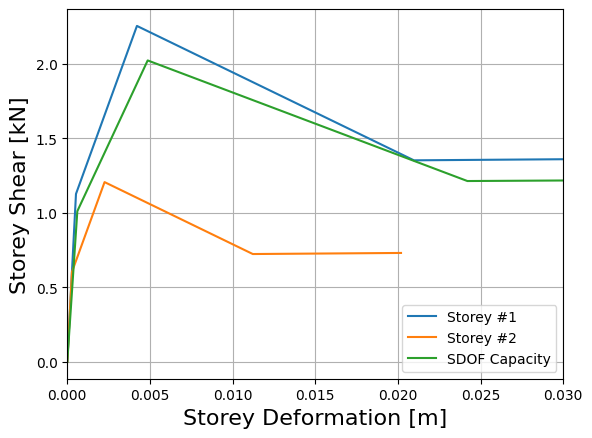

In [3]:
# Calibrate the model using the Lu et al. (2020) method
floor_masses, storey_disps, storey_forces, mdof_phi = calibrate_model(number_storeys, gamma, sdof_capacity, isFrame, isSOS)

print('The mass of each floor (in tonnes):', floor_masses)
print('The first-mode shape used for calibration:', mdof_phi)

# Plot the capacities to visualise the outcome of the calibration
for i in range(storey_disps.shape[0]):
   plt.plot(np.concatenate(([0.0], storey_disps[i,:])), np.concatenate(([0.0], storey_forces[i,:]*9.81)), label = f'Storey #{i+1}')
plt.plot(np.concatenate(([0.0], sdof_capacity[:,0])), np.concatenate(([0.0], sdof_capacity[:,1]*9.81)), label = 'SDOF Capacity')
plt.xlabel('Storey Deformation [m]', fontsize= 16)
plt.ylabel('Storey Shear [kN]', fontsize = 16)
plt.legend(loc = 'lower right')
plt.grid(visible=True, which='major')
plt.grid(visible=True, which='minor')
plt.xlim([0.00, 0.03])
plt.show()

## Compile and construct MDOF Stick Model & Run Static (Monotonic) Pushover Analysis in OpenSees ## 

WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


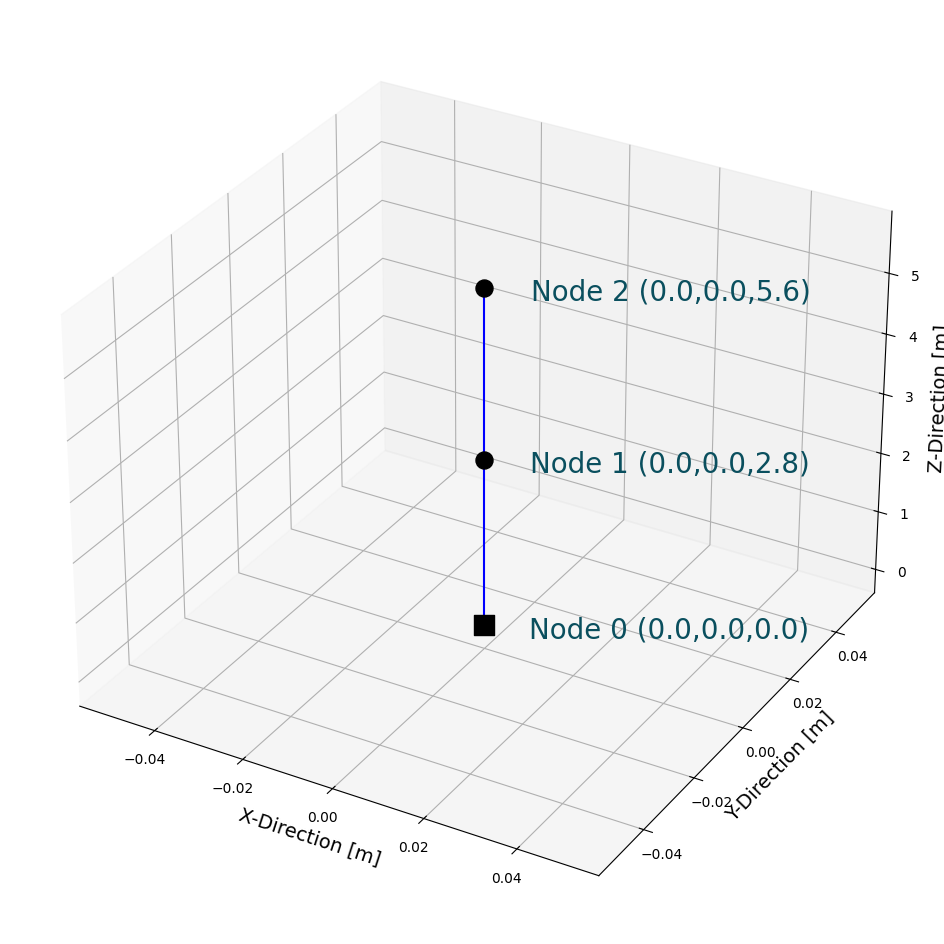

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
ANALYSIS COMPLETED!


In [4]:
### Compile the MDOF model    
model = modeller(number_storeys,
                 floor_heights,
                 floor_masses,
                 storey_disps,
                 storey_forces*units.g,
                 mdof_degradation)         # Initialise the class (Build the model)
model.compile_model()                      # Compile the MDOF model    

### View the model
model.plot_model()                         # Visualise the model      

### Do gravity analysis
model.do_gravity_analysis()                # Do gravity analysis

### Do modal analysis
T, phi = model.do_modal_analysis(num_modes = number_storeys)   # Do modal analysis and get period of vibration

### Define pushover analysis parameters
ref_disp = 0.005       # Reference displacement
disp_scale_factor = 15 # Multiplier of the reference displacement
push_dir = 1           # Push direction (for X-direction:1, for Y-direction=2)
phi = mdof_phi         # Load pattern (In this example, we apply the first-mode shape obtained from the calibration method)

### Do pushover analysis
results = model.do_spo_analysis(ref_disp, 
                                disp_scale_factor, 
                                push_dir, 
                                phi, 
                                pflag=False, 
                                num_steps=200, 
                                ansys_soe='BandGeneral', 
                                constraints_handler='Transformation', 
                                numberer='RCM', 
                                test_type='EnergyIncr', 
                                init_tol=1.0e-5, 
                                init_iter=1000, 
                                algorithm_type='KrylovNewton')

print('ANALYSIS COMPLETED!')

## Explore the Results of the Static Pushover Analysis ##

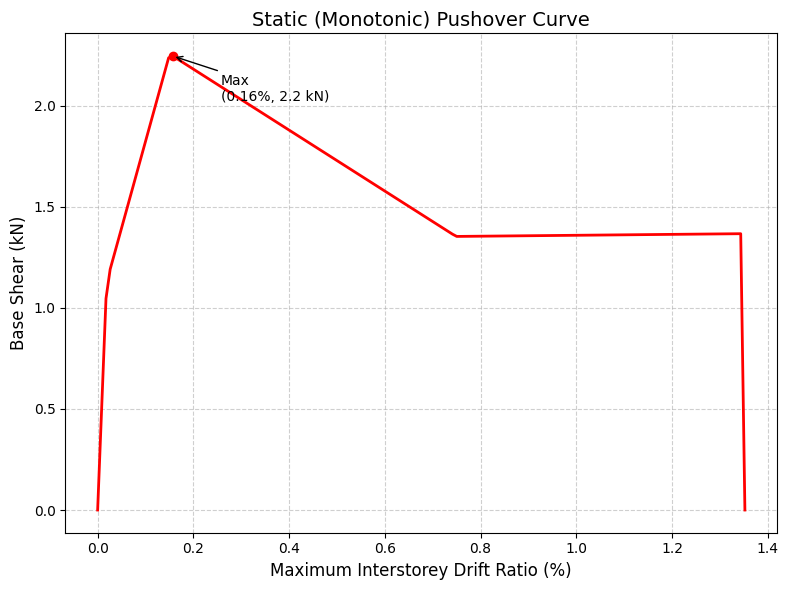

In [5]:
### Unpack the SPO results
spo_disps         = results[0] # Displacements at each control node (i.e., floor)
spo_rxn           = results[1] # Reaction at base (Base shear)
spo_disps_spring  = results[2] # Displacements in nonlinear springs (i.e., zero-length elements)
spo_forces_spring = results[3] # Forces in nonlinear springs (i.e., zero-length elements)

### Calculate the maximum interstorey drifts from the SPO results
# Step 1: Prepend ground floor (zero displacement)
ground_disps = np.zeros((spo_disps.shape[0], 1))
spo_disps = np.hstack([ground_disps, spo_disps])

# Step 2: Compute interstorey displacements
spo_isd = np.diff(spo_disps, axis=1)  # shape: (timesteps, number_storeys)

# Step 3: Normalize by corresponding floor heights
# Broadcast floor_height over each row (timesteps)
spo_idr = (spo_isd / floor_heights) * 100  # Result: (timesteps, number_storeys)

# Step 4: Take the maximum interstorey drift 
spo_midr = np.max(spo_idr, axis=1)

### Plot Static Pushover Results
plt.figure(figsize=(8, 6))
plt.plot(spo_midr, spo_rxn, linestyle='-', linewidth=2, color = 'red', label = 'Static Pushover Curve')

# Add axis labels and title
plt.xlabel("Maximum Interstorey Drift Ratio (%)", fontsize=12)
plt.ylabel("Base Shear (kN)", fontsize=12)
plt.title("Static (Monotonic) Pushover Curve", fontsize=14)

# Annotate the peak point
max_idx = np.argmax(spo_rxn)
plt.plot(spo_midr[max_idx], spo_rxn[max_idx], 'ro')
plt.annotate(f'Max\n({spo_midr[max_idx]:.2f}%, {spo_rxn[max_idx]:.1f} kN)',
             xy=(spo_midr[max_idx], spo_rxn[max_idx]),
             xytext=(spo_midr[max_idx] + 0.1, spo_rxn[max_idx] * 0.9),
             arrowprops=dict(arrowstyle='->'))

# Add grid and show
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## Compile and construct MDOF Stick Model & Run Cyclic Pushover Analysis in OpenSees ##

WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


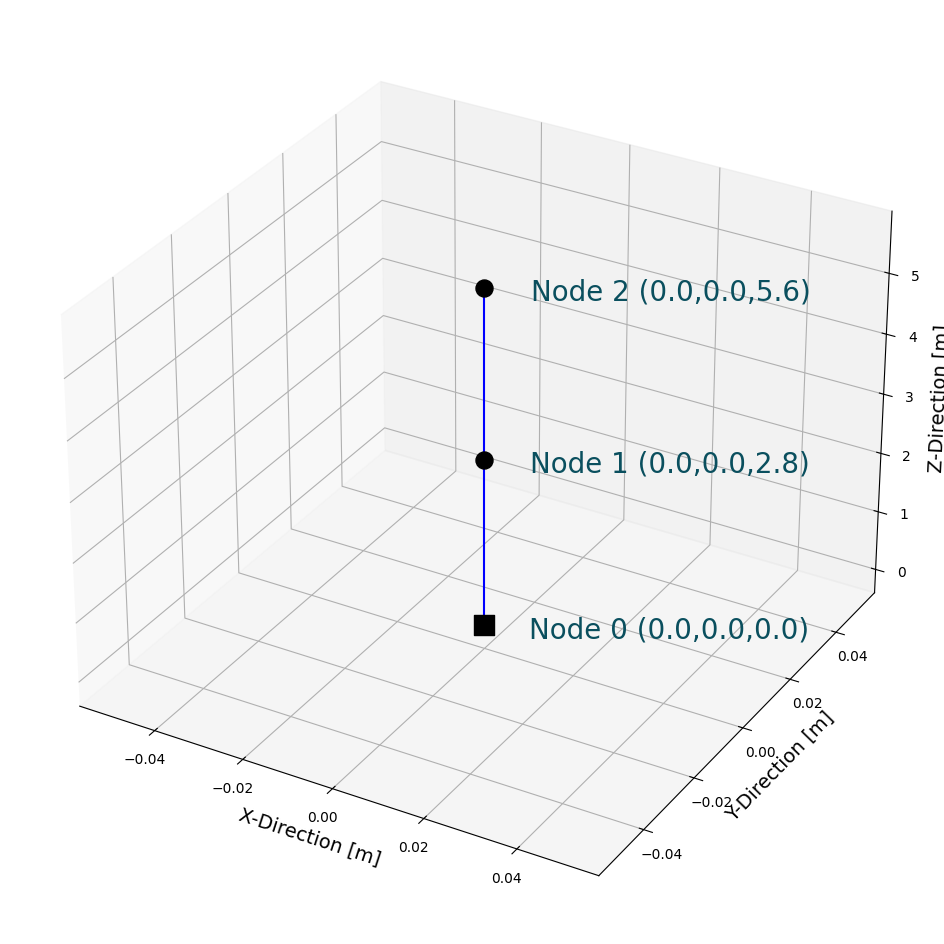

ANALYSIS COMPLETED!


In [8]:
### Compile the MDOF model    
model = modeller(number_storeys,
                 floor_heights,
                 floor_masses,
                 storey_disps,
                 storey_forces*units.g,
                 mdof_degradation)         # Initialise the class (Build the model)
model.compile_model()                      # Compile the MDOF model    

### View the model
model.plot_model()                         # Visualise the model      

### Do gravity analysis
model.do_gravity_analysis()                # Do gravity analysis

### Do modal analysis
T, phi = model.do_modal_analysis(num_modes = number_storeys)   # Do modal analysis and get period of vibration

### Define pushover analysis parameters
ref_disp = 0.001                               # Reference displacement
mu_levels = [1,2,4,6,8,10,12,15,20,25,30,50]   # Target ductility factor 
dispIncr = 5                                   # The number of displacement increments for each loading cycle
phi = mdof_phi                                 # Load pattern (In this example, we apply the first-mode shape obtained from the calibration method)

### Do pushover analysis
results = model.do_cpo_analysis(ref_disp,
                                mu_levels, 
                                push_dir, 
                                dispIncr, 
                                phi,
                                pflag=False, 
                                num_steps=200, 
                                ansys_soe='BandGeneral', 
                                constraints_handler='Transformation', 
                                numberer='RCM', 
                                test_type='NormDispIncr', 
                                init_tol=1.0e-5, 
                                init_iter=1000,
                                algorithm_type='KrylovNewton')

print('ANALYSIS COMPLETED!')

## Explore the Results of the Cyclic Pushover Analysis ## 

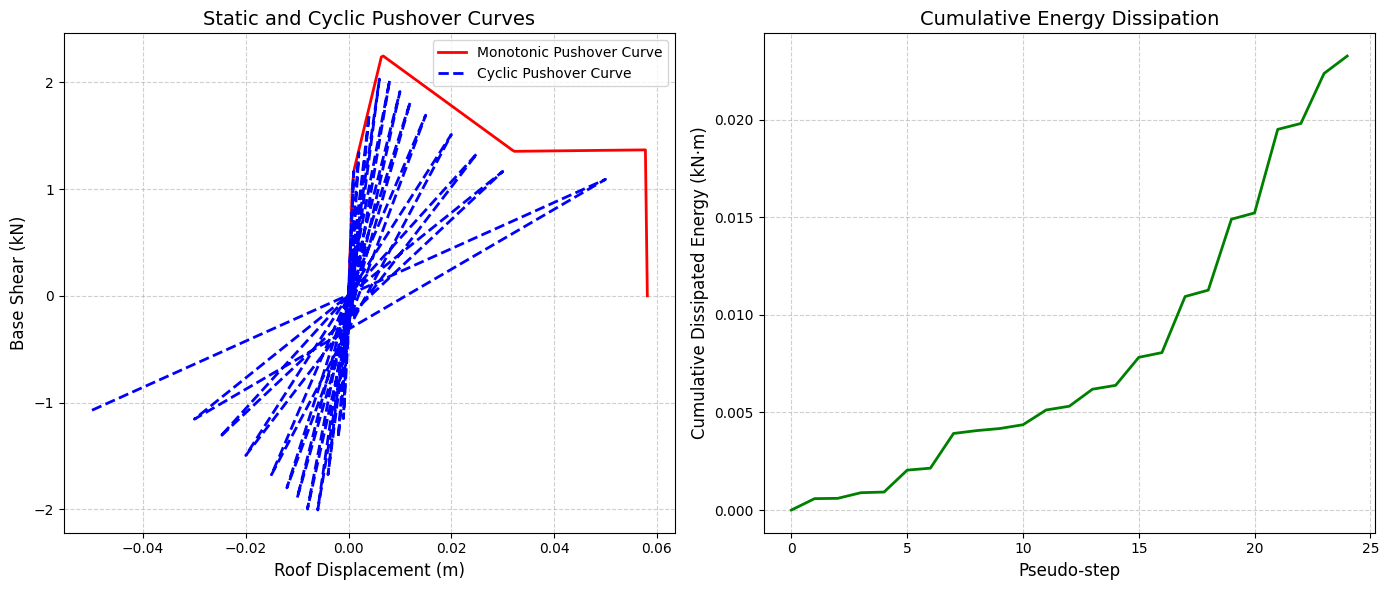

In [9]:
# Unpack results
cpo_disps  = results[0]  # Displacements at each control node (i.e., floor)
cpo_rxn    = results[1]  # Reaction at base (Base shear)
cpo_energy = results[2]  # Cumulative Dissipated Energy

roof_disp = cpo_disps[:, -1]  # Roof displacement time history

### Plot Cyclic Pushover Results with Monotonic Pushover Curve 
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# --- Subplot 1: Cyclic Pushover Curve ---
axs[0].plot(spo_disps[:, -1], spo_rxn, color='red', linewidth=2, label = 'Monotonic Pushover Curve')
axs[0].plot(roof_disp, cpo_rxn, color='blue', linewidth=2, linestyle='--', label = 'Cyclic Pushover Curve')
axs[0].set_xlabel("Roof Displacement (m)", fontsize=12)
axs[0].set_ylabel("Base Shear (kN)", fontsize=12)
axs[0].set_title("Static and Cyclic Pushover Curves", fontsize=14)
axs[0].grid(True, linestyle='--', alpha=0.6)
axs[0].legend()

# --- Subplot 2: Cumulative Dissipated Energy ---
axs[1].plot(cpo_energy[:, 0], cpo_energy[:, 1], color='green', linewidth=2)
axs[1].set_xlabel("Pseudo-step", fontsize=12)
axs[1].set_ylabel("Cumulative Dissipated Energy (kN·m)", fontsize=12)
axs[1].set_title("Cumulative Energy Dissipation", fontsize=14)
axs[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()